<a href="https://colab.research.google.com/github/leileihao/slc/blob/main/Next_REM_Prediction%20Random%20Forest%20Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Imports

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import os
import re
import numpy as np
import scipy.io as so
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import math
from datetime import datetime
from sklearn.metrics import f1_score, roc_auc_score
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms
from torch import sparse
from torchvision.transforms import ToTensor
from torchvision.transforms import Normalize
from torch.autograd import Variable
from pandas import Series
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
!pip install pingouin
import pingouin as pg
import seaborn as sns
import matplotlib.pyplot as plt
import sys
import scipy



def get_sequences(idx, ibreak=1, return_empty=False):
    """
    get_sequences(idx, ibreak=1)
    idx     -    np.vector of indices
    @RETURN:
    seq     -    list of np.vectors

    NOTE: if there's no sequence, then the function returns a list with
    an empty np.array ([np.array([])])
    """
    diff = idx[1:] - idx[0:-1]
    breaks = np.nonzero(diff>ibreak)[0]
    breaks = np.append(breaks, len(idx)-1)

    seq = []
    iold = 0
    for i in breaks:
        r = list(range(iold, i+1))
        seq.append(idx[r])
        iold = i+1

    if return_empty:
        if len(seq) == 1 and seq[0].size == 0:
            return []
    else:
        return seq


def get_sr(ppath, name):
    """
    read and return sampling rate (SR) from the info.txt file $ppath/$name/info.txt
    """
    fid = open(os.path.join(ppath, name, 'info.txt'), newline=None)
    lines = fid.readlines()
    fid.close()
    values = []
    for l in lines :
        a = re.search("^" + 'SR' + ":" + "\s+(.*)", l)
        if a :
            values.append(a.group(1))
    return float(values[0])

<>:74: SyntaxWarning: invalid escape sequence '\s'
<>:74: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipython-input-2754331610.py:74: SyntaxWarning: invalid escape sequence '\s'
  a = re.search("^" + 'SR' + ":" + "\s+(.*)", l)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 204.4/204.4 kB 8.7 MB/s eta 0:00:00


In [ ]:
def time_morph(X, nstates):
    """
    upsample vector or matrix X to nstates states
    :param X, vector or matrix; if matrix, the rows are upsampled.
    :param nstates, number of elements or rows of returned vector or matrix
    I want to upsample m by a factor of x such that
    x*m % nstates == 0,
    a simple soluation is to set x = nstates
    then nstates * m / nstates = m.
    so upsampling X by a factor of nstates and then downsampling by a factor
    of m is a simple solution...
    """
    m = X.shape[0]
    A = upsample_mx(X, nstates)
    # now we have m * nstates rows
    if X.ndim == 1:
        Y = downsample_vec(A, int((m * nstates) / nstates))
    else:
        Y = downsample_mx(A, int((m * nstates) / nstates))
    # now we have m rows as requested
    return Y

def upsample_mx(x, nbin):
    """
    if x is a vector:
        upsample the given vector $x by duplicating each element $nbin times
    if x is a 2d array:
        upsample each matrix by duplication each row $nbin times
    """
    if nbin == 1:
        return x

    nelem = x.shape[0]
    if x.ndim == 1:
        y = np.zeros((nelem * nbin,))
        for k in range(nbin):
            y[k::nbin] = x
    else:
        y = np.zeros((nelem * nbin, x.shape[1]))
        for k in range(nbin):
            y[k::nbin, :] = x

    return y

def downsample_mx(X, nbin):
    """
    y = downsample_vec(x, nbin)
    downsample the vector x by replacing nbin consecutive
    bin by their mean
    @RETURN: the downsampled vector
    """
    n_down = int(np.floor(X.shape[0] / nbin))
    X = X[0:n_down * nbin, :]
    X_down = np.zeros((n_down, X.shape[1]))

    # 0 1 2 | 3 4 5 | 6 7 8
    for i in range(nbin):
        idx = list(range(i, int(n_down * nbin), int(nbin)))
        X_down += X[idx, :]

    return X_down / nbin

def downsample_vec(x, nbin):
    """
    y = downsample_vec(x, nbin)
    downsample the vector x by replacing nbin consecutive \
    bin by their mean \
    @RETURN: the downsampled vector
    """
    n_down = int(np.floor(len(x) / nbin))
    x = x[0:n_down*nbin]
    x_down = np.zeros((n_down,))

    # 0 1 2 | 3 4 5 | 6 7 8
    for i in range(nbin) :
        idx = list(range(i, int(n_down*nbin), int(nbin)))
        x_down += x[idx]

    return x_down / nbin

In [ ]:
def load_stateidx(ppath, name, ann_name=''):
    """ load the sleep state file of recording (folder) $ppath/$name
    @Return:
        M,K         sequence of sleep states, sequence of
                    0'1 and 1's indicating non- and annotated states
    """
    ddir = os.path.join(ppath, name)
    ppath, name = os.path.split(ddir)

    if ann_name == '':
        ann_name = name

    remidxfile3 = os.path.join(ppath, name, '3_remidx_' + ann_name + '.txt')
    remidxfile_regular = os.path.join(ppath, name, 'remidx_' + ann_name + '.txt')

    # Check if '3_remidx_' file exists, if not use 'remidx_' file
    if os.path.exists(remidxfile3):
      remidxfile = remidxfile3
      print('3_remdix')

    else:
      remidxfile = remidxfile_regular
      print('remdix')


    f = open(remidxfile, 'r')
    lines = f.readlines()
    f.close()

    n = 0
    for l in lines:
        if re.match('\d', l):
            n += 1

    M = np.zeros(n, dtype='int')
    K = np.zeros(n, dtype='int')

    i = 0
    for l in lines :

        if re.search('^\s+$', l) :
            continue
        if re.search('\s*#', l) :
            continue

        if re.match('\d+\s+-?\d+', l) :
            a = re.split('\s+', l)
            M[i] = int(a[0])
            K[i] = int(a[1])
            i += 1

    return M,K

def smooth_data(x, sig):
    """
    y = smooth_data(x, sig)
    smooth data vector @x with gaussian kernel
    with standard deviation $sig
    """
    sig = float(sig)
    if sig == 0.0:
        return x

    # gaussian:
    gauss = lambda x, sig : (1/(sig*np.sqrt(2.*np.pi)))*np.exp(-(x*x)/(2.*sig*sig))

    bound = 1.0/10000
    L = 10.
    p = gauss(L, sig)
    while (p > bound):
        L = L+10
        p = gauss(L, sig)

    #F = map(lambda x: gauss((x, sig)), np.arange(-L, L+1.))
    # py3:
    F = [gauss(x, sig) for x in np.arange(-L, L+1.)]
    F = F / np.sum(F)

    return scipy.signal.fftconvolve(x, F, 'same')

def my_bpfilter(x, w0, w1, N=4,bf=True):
    """
    create N-th order bandpass Butterworth filter with corner frequencies
    w0*sampling_rate/2 and w1*sampling_rate/2
    """
    #from scipy import signal
    #taps = signal.firwin(numtaps, w0, pass_zero=False)
    #y = signal.lfilter(taps, 1.0, x)
    #return y
    from scipy import signal
    b,a = signal.butter(N, [w0, w1], 'bandpass')
    if bf:
        y = signal.filtfilt(b,a, x)
    else:
        y = signal.lfilter(b,a, x)

    return y

def my_lpfilter(x, w0, N=4):
    """
    create a lowpass Butterworth filter with a cutoff of w0 * the Nyquist rate.
    The nice thing about this filter is that is has zero-phase distortion.
    A conventional lowpass filter would introduce a phase lag.

    w0   -    filter cutoff; value between 0 and 1, where 1 corresponds to nyquist frequency.
              So if you want a filter with cutoff at x Hz, the corresponding w0 value is given by
                                w0 = 2 * x / sampling_rate
    N    -    order of filter
    @Return:
        low-pass filtered signal

    See also my hp_filter, or my_bpfilter
    """
    from scipy import signal

    b,a = signal.butter(N, w0)
    y = signal.filtfilt(b,a, x)

    return y

<>:32: SyntaxWarning: invalid escape sequence '\d'
<>:41: SyntaxWarning: invalid escape sequence '\s'
<>:43: SyntaxWarning: invalid escape sequence '\s'
<>:46: SyntaxWarning: invalid escape sequence '\d'
<>:47: SyntaxWarning: invalid escape sequence '\s'
<>:32: SyntaxWarning: invalid escape sequence '\d'
<>:41: SyntaxWarning: invalid escape sequence '\s'
<>:43: SyntaxWarning: invalid escape sequence '\s'
<>:46: SyntaxWarning: invalid escape sequence '\d'
<>:47: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipython-input-4111210346.py:32: SyntaxWarning: invalid escape sequence '\d'
  if re.match('\d', l):
/tmp/ipython-input-4111210346.py:41: SyntaxWarning: invalid escape sequence '\s'
  if re.search('^\s+$', l) :
/tmp/ipython-input-4111210346.py:43: SyntaxWarning: invalid escape sequence '\s'
  if re.search('\s*#', l) :
/tmp/ipython-input-4111210346.py:46: SyntaxWarning: invalid escape sequence '\d'
  if re.match('\d+\s+-?\d+', l) :
/tmp/ipython-input-4111210346.py:47: SyntaxWarning:

In [ ]:
# Check that GPU is being used for model
torch.manual_seed(42) # For consistency
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(torch.__version__)
print(device)

2.8.0+cu126
cuda:0


## Data Loading

In [ ]:
from torch import sparse
# Bidirectional LSTM
class biLSTM(nn.Module):
  def __init__(self, input_size, window_len, hidden_size=128, num_layers=2, dropout=0.2):
    super(biLSTM, self).__init__()
    self.hidden_size = hidden_size
    self.num_layers = num_layers
    self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers,
                            dropout=dropout, batch_first=True, bidirectional=True)
    self.fc = nn.Sequential(
          nn.BatchNorm1d(hidden_size*2),
          nn.Linear(hidden_size*2, hidden_size),
          nn.ReLU(),
          nn.BatchNorm1d(hidden_size),
          nn.Linear(hidden_size, 64),
          nn.ReLU(),
          nn.Linear(64, 3), # three brain states: 1, 2, 3 (--> now 0, 1, 2 due to shift)
    )

    self.softmax = nn.Softmax(dim=1)
    self.dropout = nn.Dropout(dropout)


  def forward(self, x):
    batch_size, seq_len, num_channels = x.size()

    h0 = torch.randn(2 * self.num_layers, batch_size, self.hidden_size).double().to(device)
    c0 = torch.randn(2 * self.num_layers, batch_size, self.hidden_size).double().to(device)

    x = x.permute(0, 1, 2)  # Transpose the tensor to match the shape (batch, seq_len, num_channels)

    outl, _ = self.lstm(x, (h0, c0))
    out = outl[:, -1, :]

    out = self.fc(out)
    return out


In [ ]:
import io
import pickle
class CPU_Unpickler(pickle.Unpickler):
    def find_class(self, module, name):
        if module == 'torch.storage' and name == '_load_from_bytes':
            return lambda b: torch.load(io.BytesIO(b), map_location=device)
        else: return super().find_class(module, name)

biLSTM_model = CPU_Unpickler(open('/content/drive/MyDrive/MultiVanillaModelPart1N.pkl',"rb")).load()

In [ ]:
def find_intervals(df, start_indices, end_indices, i, nrem_count=7499):
    total_inter_rem_len = start_indices[i] - end_indices[i]
    intervals = []
    times_until_end = []
    idx = 0 # index going through the sequence
    start = 0 # keeps track of the start of the next interval
    nrem_sequences = 0 # how many nrem has been seen

    while idx < total_inter_rem_len:
        idx += 1
        # Check the current state, modified version doesn't need to just be NREM
        if True: #df.loc[end_indices[i] + idx, 'State'] == 3:
            nrem_sequences += 1

        # If we have collected enough NREM sequences, record the interval
        if nrem_sequences == nrem_count:
            end = idx + end_indices[i]  # Record the current index as the end
            intervals.append((end_indices[i] + start, end))
            times_until_end.append(total_inter_rem_len - idx - 1)
            nrem_sequences = 0  # Reset the NREM counter
            start = idx



    return intervals, times_until_end


In [ ]:
import random
from sklearn.decomposition import PCA

# Concatenate the EEG, EMG, and sleep state (M) of the list of recordings
ppath = '/content/drive/MyDrive/SleepClass/24Train'

recordings = os.listdir(ppath)


random.seed(2)
selected_recordings = random.sample(recordings, 5)
print(selected_recordings)

ndown = 4
factor = 2500 #(time bin * sampling rate)
validation_split = 0.2

all_data = []
count = 0
for name in selected_recordings:
  m = load_stateidx(ppath, name)[0]
  m = m.astype('i')
  m = m[:-1] # cut off the end that doesn't match
  len_m = len(m)

  sr = get_sr(ppath, name)
  w1 = 10 / (sr/2)
  w2 = 15 / (sr/2)

  eeg = so.loadmat(os.path.join(ppath, name, 'EEG.mat'), squeeze_me=True)['EEG']
  # eeg_bp = my_lpfilter(eeg, w2)
  eeg = eeg[:(len_m) * factor]    # truncate eeg length to the number of windows
  eeg = downsample_vec(eeg, ndown)
  #eeg = np.random.randn(*eeg.shape)
  eeg = eeg.astype('float16')
  np.random.shuffle(eeg)

  emg = so.loadmat(os.path.join(ppath, name, 'EMG.mat'), squeeze_me=True)['EMG']
  # emg_bp = my_bpfilter(emg, w1, w2)
  emg = emg[:(len_m) * factor]
  emg = downsample_vec(emg, ndown)
  #emg = np.random.randn(*emg.shape)
  emg = emg.astype('float16')
  np.random.shuffle(emg)

  # Change all the sleep states above 3 to NREM -- can change to separate out microarousals
  for i in range(len(m)):
    if m[i] > 3:
      m[i] = 3
    if m[i] == 0: # changed the unannotated segments to NREM
      m[i] = 3

  EEG_EMG = np.vstack((eeg, emg)).T
  M = np.repeat(m, int(factor / ndown))

  df = pd.DataFrame(columns=['EEG', 'EMG', 'State'])

  # Assign data from the existing arrays or Series to the new DataFrame
  df['EEG'] = EEG_EMG[:, 0]  # Assuming EEG is the first column in EEG_EMG
  df['EMG'] = EEG_EMG[:, 1]  # Assuming EMG is the second column in EEG_EMG
  df['State'] = M.astype('int8')

  # df['State'] = df['State'].replace({1: 'REM', 2: 'Wake', 3: 'NREM'})

  df_rem_bouts = df[df['State'] == 1]
  df_rem_bouts.loc[:, 'difference'] = df_rem_bouts.index.to_series().diff()

  first_rem = df_rem_bouts.index[0]
  df_rem_start = df_rem_bouts[df_rem_bouts['difference'] > 1]
  start_indices = df_rem_start.index.to_list() # note the first start index is the beginning of the second REM in the recording
  float_indices = df_rem_start.index - df_rem_start['difference'].to_list()
  end_indices = [int(i) for i in float_indices]

  for i in range(len(end_indices)): # loop throigh the end of each REM
      # state_values = df.loc[end_indices[i]:start_indices[i], 'State'].values
      # portion_of_wake = np.sum(state_values == 2) / len(state_values)
      # if portion_of_wake < 0.60:
      intervals, times_until_end = find_intervals(df, start_indices, end_indices, i)

      if i == 0: # figure out the length of the first rem
        pre_rem = end_indices[i] - first_rem
      else:
        pre_rem = end_indices[i] - start_indices[i-1]

      if i < len(start_indices) - 1:  # Check if it's not the last REM episode
          post_rem = end_indices[i+1] - start_indices[i]
      else:
          post_rem = 0

      total_duration = start_indices[i] - end_indices[i]

      for k in range(len(intervals)):
        duration = intervals[k][1] - intervals[k][0]
        start_segment = intervals[k][0]
        end_segment = intervals[k][1]

        clipped_eeg = df.loc[start_segment:end_segment, 'EEG'].values.view('float16')
        clipped_emg = df.loc[start_segment:end_segment, 'EMG'].values.view('float16')
        clipped_m = df.loc[start_segment:end_segment, 'State'].values.view('int8')

        # # # if np.all(clipped_m == 3):
        # if post_rem / 625 > 8 and pre_rem / 625 > 8:  # both post and preREM is longer than 20 seconds
        # #     # if count % 2 != 0:
        all_data += zip([clipped_eeg], [clipped_emg], [times_until_end[k]], [pre_rem], [post_rem], [total_duration], [clipped_m])





['AC3_101420n1', 'AC87_082321n1', 'AC139_061322n1', 'AC2_101420n1', 'AC171_072722n1']
remdix


/tmp/ipython-input-1111562715.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_rem_bouts.loc[:, 'difference'] = df_rem_bouts.index.to_series().diff()


remdix


/tmp/ipython-input-1111562715.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_rem_bouts.loc[:, 'difference'] = df_rem_bouts.index.to_series().diff()


remdix


/tmp/ipython-input-1111562715.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_rem_bouts.loc[:, 'difference'] = df_rem_bouts.index.to_series().diff()


remdix


/tmp/ipython-input-1111562715.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_rem_bouts.loc[:, 'difference'] = df_rem_bouts.index.to_series().diff()


remdix


/tmp/ipython-input-1111562715.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_rem_bouts.loc[:, 'difference'] = df_rem_bouts.index.to_series().diff()


In [ ]:
all_data_df = pd.DataFrame(all_data, columns=['EEG', 'EMG', 'time (s) until next REM', 'previous rem duration', 'next rem duration', 'inter-rem duration', 'State'])
all_data_df['Elapsed Time'] = all_data_df['inter-rem duration'] - all_data_df['time (s) until next REM']

In [ ]:
all_data_df['Elapsed Time'] = (all_data_df['Elapsed Time'] / 625).round().astype(int)
all_data_df['time (s) until next REM'] = (all_data_df['time (s) until next REM'] / 625).round().astype(int)
all_data_df['previous rem duration'] = (all_data_df['previous rem duration'] / 625).round().astype(int)
all_data_df['inter-rem duration'] = (all_data_df['inter-rem duration'] / 625).round().astype(int)
all_data_df['next rem duration'] = (all_data_df['next rem duration'] / 625).round().astype(int)

In [ ]:
# all_data_df = all_data_df.loc[all_data_df['time (s) until next REM'] > 24]
# all_data_df['time (s) until next REM'] = all_data_df['time (s) until next REM'].apply(np.log)

In [ ]:
# !sudo apt install ttf-mscorefonts-installer
# !apt-get install -y fonts-arial
# import matplotlib.pyplot as plt
# import matplotlib.font_manager as font_manager

# # Add Arial font to Matplotlib's font manager
# font_dir = ['/usr/share/fonts/truetype/msttcorefonts']
# for font in font_manager.findSystemFonts(font_dir):
#     font_manager.fontManager.addfont(font)

# # Set Arial as the default font for Matplotlib
# plt.rcParams['font.family'] = 'Arial'

In [ ]:
percentile_95 = all_data_df['inter-rem duration'].quantile(0.95)

In [ ]:
# plt.figure(figsize=(8, 8))
# sns.set_style("white")
# sns.histplot(all_data_df['inter-rem duration'], bins=20, kde=False, color="#ff7f24")  # Customize bins and colors
# plt.title('Distribution of Inter-REM Duration', fontsize=30)
# plt.xlabel('Inter-REM Duration (s)', fontsize=28)
# plt.ylabel('Frequency', fontsize=28)
# plt.xticks(fontsize=24)
# plt.xticks(rotation=315)
# plt.yticks(fontsize=24)
# sns.despine(top=True, right=True)
# plt.rcParams['font.family'] = 'Arial'
# plt.axvline(x=percentile_95, color='red', linestyle='--', label=f'95th Percentile')
# plt.grid(False)
# plt.legend(fontsize=20, frameon=False)
# plt.show()

In [ ]:
all_data_df = all_data_df.loc[all_data_df['inter-rem duration'] < percentile_95]

In [ ]:
# sns.histplot(all_data_df['inter-rem duration'], bins=20, kde=False, color='skyblue')  # Customize bins and colors
# plt.title('Distribution of Inter-REM Duration after 95th cutoff', fontsize=16)
# plt.xlabel('Inter-REM Duration', fontsize=14)
# plt.ylabel('Frequency', fontsize=14)
# plt.grid(True, linestyle='--', alpha=0.7)
# plt.show()

In [ ]:
all_data_df['EEG_length'] = all_data_df['EEG'].apply(len)
all_data_df['EMG_length'] = all_data_df['EMG'].apply(len)

In [ ]:
n_samples = len(all_data_df)
n_train = int(0.8 * n_samples)
all_indices = list(range(n_samples))
random.shuffle(all_indices)

train_indices = all_indices[:n_train]
test_indices = all_indices[n_train:]

In [ ]:
scaler = StandardScaler()

eeg_train = [item for sublist in [all_data_df.iloc[i, 0] for i in train_indices] for item in sublist]
emg_train = [item for sublist in [all_data_df.iloc[i, 1] for i in train_indices] for item in sublist]
EEG_EMG_train = scaler.fit_transform(np.vstack((eeg_train, emg_train)).T)
del eeg_train
del emg_train

m_train = [item for sublist in [all_data_df.iloc[i, 6] for i in train_indices] for item in sublist]

eeg_test = [item for sublist in [all_data_df.iloc[i, 0] for i in test_indices] for item in sublist]
emg_test = [item for sublist in [all_data_df.iloc[i, 1] for i in test_indices] for item in sublist]
EEG_EMG_test = scaler.transform(np.vstack((eeg_test, emg_test)).T)
del eeg_test
del emg_test

m_test = [item for sublist in [all_data_df.iloc[i, 6] for i in test_indices] for item in sublist]

time_until_REM_train = [all_data_df.iloc[i, 2] for i in train_indices]
time_until_REM_test = [all_data_df.iloc[i, 2] for i in test_indices]
REMpre_train = [all_data_df.iloc[i, 3] for i in train_indices]
REMpre_test = [all_data_df.iloc[i, 3] for i in test_indices]
REMpost_train = [all_data_df.iloc[i, 4] for i in train_indices]
REMpost_test = [all_data_df.iloc[i, 4] for i in test_indices]
elapsed_time_train = [all_data_df.iloc[i, 7] for i in train_indices]
elapsed_time_test = [all_data_df.iloc[i, 7] for i in test_indices]

In [ ]:
del all_data_df

In [ ]:
# Data loader for stage 1
class CustomDataset(Dataset):
    def __init__(self, data, labels, window_size):
        self.data = torch.tensor(data, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.uint8)
        self.window_size = window_size

    def __len__(self):
        return len(self.data) // self.window_size

    def __getitem__(self, index):
        x = self.data[index*window_size:index*window_size+window_size][:]
        print()
        if (index*window_size >= (len(self.data) - window_size)):
            y = self.labels[index*window_size-1]
        else:
            # so it doesn't have an out of bound
            y = self.labels[index*window_size]

        y = y.long()

        # Perform one-hot encoding on y
        y = y - 1  # shift the labels to start at 0
        y_encoded = F.one_hot(y, num_classes=3)

        x = x.view(-1, 2)

        return x, y_encoded


# Data loader for stage 2
class CustomDatasetFC(Dataset):
    def __init__(self, data, labels):
        self.data = torch.tensor(data, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.int64)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        x = self.data[index]
        y = self.labels[index]

        return x, y

In [ ]:
window_size = 625
input_size = 2
train_dataset = CustomDataset(EEG_EMG_train, m_train, window_size=window_size)
test_dataset = CustomDataset(EEG_EMG_test, m_test, window_size=window_size)

# Create data loaders
batch_size = 120
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
biLSTM_model.eval()
hidden_values_train = []
hidden_values_test = []
real_labels_train = []
real_labels_test = []

with torch.no_grad():
  for iter, (input, target) in enumerate(train_loader):
      input = input.to(device).double()
      target = target.to(device).double()

      output = biLSTM_model(input)

      hidden_values_train.extend(output.tolist())
      real_labels_train.extend(target.tolist())

with torch.no_grad():
  for iter, (input, target) in enumerate(test_loader):
      input = input.to(device).double()
      target = target.to(device).double()

      output = biLSTM_model(input)

      hidden_values_test.extend(output.tolist())
      real_labels_test.extend(target.tolist())

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:1124: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at /pytorch/aten/src/ATen/native/cudnn/RNN.cpp:1479.)
  result = _VF.lstm(


Streaming output truncated to the last 5000 lines.























































































































































































































































































































































































































































































































































































































































































































































































































































































































































































In [ ]:
train_len = len(REMpre_train)
test_len = len(REMpre_test)

In [ ]:
labels_test = pd.from_dummies(pd.DataFrame(real_labels_test))
# labels_test = labels_test.replace(0, "REM")
# labels_test = labels_test.replace(1, "Wake")
# labels_test = labels_test.replace(2, "NREM")

labels_train = pd.from_dummies(pd.DataFrame(real_labels_train))
# labels_train = labels_train.replace(0, "REM")
# labels_train = labels_train.replace(1, "Wake")
# labels_train = labels_train.replace(2, "NREM")

In [ ]:
values_train = np.array(hidden_values_train).reshape(train_len, -1)
values_test = np.array(hidden_values_test).reshape(test_len, -1)
labels_train = np.array(labels_train).reshape(train_len, -1)
labels_test = np.array(labels_test).reshape(test_len, -1)

In [ ]:
df_train = pd.DataFrame(values_train)
df_train['REMpre'] = REMpre_train
df_train['elapsed_time'] = elapsed_time_train
df_train['time_until_REM'] = time_until_REM_train
df_train['states'] = labels_train.tolist()
df_train['eeg_emg'] = df_train.iloc[:, 0:36].values.tolist()
df_train = df_train.drop(df_train.columns[0:36], axis=1)

In [ ]:
len(df_train['eeg_emg'][0]) #  comes from a (12, 3) shaped array flattened. It is 12 because each point is 2.5 seconds, and 2.5* 12 = 30 seconds total

36

In [ ]:
# # Create shuffled copies
# REMpre_train_shuffled = REMpre_train.copy()  # Create a copy of REMpre_train
# elapsed_time_train_shuffled = elapsed_time_train.copy()  # Create a copy of elapsed_time_train

# # Shuffle the copies
# random.shuffle(REMpre_train_shuffled)
# random.shuffle(elapsed_time_train_shuffled)

In [ ]:
# # Create DataFrame
# df_train = pd.DataFrame(values_train)
# df_train['REMpre'] = df_train['REMpre'] = REMpre_train
# df_train['elapsed_time'] = elapsed_time_train_shuffled
# df_train['time_until_REM'] = time_until_REM_train
# df_train['states'] = labels_train.tolist()
# df_train['eeg_emg'] = df_train.iloc[:, 0:36].values.tolist()
# df_train = df_train.drop(df_train.columns[0:36], axis=1)

In [ ]:
df_test = pd.DataFrame(values_test)
df_test['REMpre'] = REMpre_test
df_test['elapsed_time'] = elapsed_time_test
df_test['time_until_REM'] = time_until_REM_test
df_test['states'] = labels_test.tolist()
df_test['eeg_emg'] = df_test.iloc[:, 0:36].values.tolist()
df_test = df_test.drop(df_test.columns[0:36], axis=1)


In [ ]:
palette = sns.color_palette("Paired")

In [ ]:
# df_test = df_test[df_test['time_until_REM'] > 30]

In [ ]:
x_train = np.hstack((df_train['eeg_emg'].tolist(), df_train['REMpre'].values.reshape(-1, 1), df_train['elapsed_time'].values.reshape(-1, 1)))
y_train = df_train['time_until_REM'].values
x_test = np.hstack((df_test['eeg_emg'].tolist(), df_test['REMpre'].values.reshape(-1, 1), df_test['elapsed_time'].values.reshape(-1, 1)))
y_test = df_test['time_until_REM'].values

In [ ]:
from sklearn.ensemble  import RandomForestRegressor

model = RandomForestRegressor(n_estimators=100)
model.fit(x_train, y_train)

RandomForestRegressor()

In [ ]:
!sudo apt install ttf-mscorefonts-installer
!apt-get install -y fonts-arial
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager

# Add Arial font to Matplotlib's font manager
font_dir = ['/usr/share/fonts/truetype/msttcorefonts']
for font in font_manager.findSystemFonts(font_dir):
    font_manager.fontManager.addfont(font)

# Set Arial as the default font for Matplotlib
plt.rcParams['font.family'] = 'Arial'

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  cabextract distro-info libmspack0 python3-chardet python3-debconf
  python3-debian python3-distro-info python3-distupgrade
  python3-update-manager python3-yaml ubuntu-advantage-tools ubuntu-pro-client
  ubuntu-pro-client-l10n ubuntu-release-upgrader-core update-manager-core
  update-notifier-common xfonts-encodings xfonts-utils zstd
Suggested packages:
  shunit2
The following NEW packages will be installed:
  cabextract distro-info libmspack0 python3-chardet python3-debconf
  python3-debian python3-distro-info python3-distupgrade
  python3-update-manager python3-yaml ttf-mscorefonts-installer
  ubuntu-advantage-tools ubuntu-pro-client ubuntu-pro-client-l10n
  ubuntu-release-upgrader-core update-manager-core update-notifier-common
  xfonts-encodings xfonts-utils zstd
0 upgraded, 20 newly installed, 0 to remove and 41 not upgraded.
Need 

SVG file saved to: /content/drive/MyDrive/SleepClass/Revision/Examples/3B REMpre, ET.svg


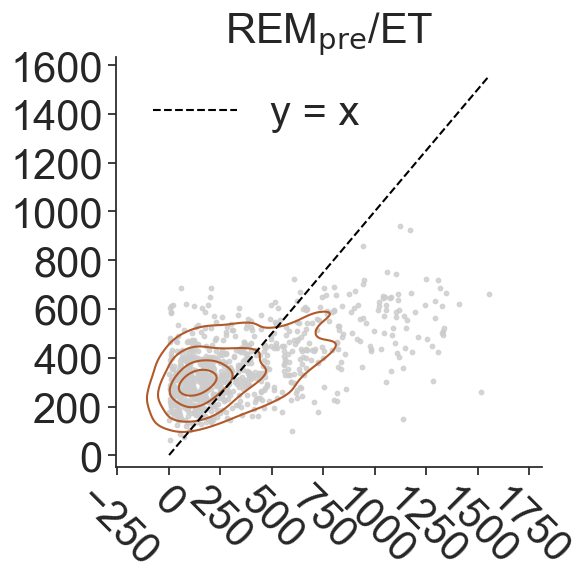

In [ ]:
from IPython.display import HTML, display
import base64

save_dir = '/content/drive/MyDrive/SleepClass/Revision/Examples'
os.makedirs(save_dir, exist_ok=True)

sns.set_style("white")
sns.set_style('ticks')
sns.regplot(x=y_test[::3], y=model.predict(x_test)[::3], fit_reg=False, scatter_kws={"color": "#CCCCCC", "s": 10})
sns.kdeplot(x=y_test[::3], y=model.predict(x_test)[::3], fill=False, levels=[0.25, 0.5, 0.75, 0.90, 1], bw_adjust=.8, color=palette[11])
sns.set(rc = {'figure.figsize':(6,6)})


min_val = min(min(y_test[::3]), min(model.predict(x_test)[::3]))
max_val = max(max(y_test[::3]), max(model.predict(x_test)[::3]))
plt.plot([min_val, max_val], [min_val, max_val], color="black",  linestyle='--', label='y = x')
plt.legend(fontsize=30, frameon=False)
# plt.xlabel('Actual time until next REM (s)', fontsize=30)
# plt.ylabel('Predicted time until next REM (s)', fontsize=30)

plt.xticks(fontsize=30, rotation=315)
plt.yticks(fontsize=30)
# plt.ylim([0, 1600])
# plt.xlim([-250, 1750])
# plt.title('EMG/REM$_{\\mathrm{pre}}$/ET (T$_{\\mathrm{REM}}$ > 30)', fontsize=20)
title = 'REM$_{\\mathrm{pre}}$/ET'
plt.title(title, fontsize=30)

sns.despine(top=True, right=True)
plt.rcParams['font.family'] = 'Arial'
plt.margins(x=0)
plt.tight_layout()
r2_score = model.score(x_test, y_test)

# Add the R^2 score as text on the plot
# plt.text(x=700, y=500, s=f'R² = {r2_score:.2f}', fontsize=20, color='black')

# Save the figure immediately after plotting
svg_filepath = os.path.join(save_dir, '3B REMpre, ET.svg')
plt.savefig(svg_filepath, format='svg')

# Display the SVG in the notebook (for verification)
with open(svg_filepath, 'r') as f:
    svg_data = f.read()
    display(HTML(f'<embed type="image/svg+xml" src="data:image/svg+xml;base64,{base64.b64encode(svg_data.encode()).decode()}" />'))

print(f"SVG file saved to: {svg_filepath}")

plt.show()

In [ ]:
r2_score

0.3745565957508489

In [ ]:
import statsmodels.api as sm
import numpy as np
predicted_times = model.predict(x_test)
actual_times = y_test
X = sm.add_constant(predicted_times)
model_stats = sm.OLS(actual_times, X).fit()
print(model_stats.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.377
Model:                            OLS   Adj. R-squared:                  0.377
Method:                 Least Squares   F-statistic:                     1440.
Date:                Wed, 19 Nov 2025   Prob (F-statistic):          8.50e-247
Time:                        04:25:59   Log-Likelihood:                -16640.
No. Observations:                2381   AIC:                         3.328e+04
Df Residuals:                    2379   BIC:                         3.330e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -15.9466     11.146     -1.431      0.1

In [ ]:
# Accessing and printing specific statistics with 10 significant figures
print(f"R-squared: {model_stats.rsquared:.10g}")
print(f"Adjusted R-squared: {model_stats.rsquared_adj:.10g}") # Often useful to print adjusted R-squared as well
print(f"F-statistic: {model_stats.fvalue:.10g}") # F-statistic for overall model significance
print(f"Prob (F-statistic): {model_stats.f_pvalue:.10g}") # P-value for overall model significance


# Information for the constant (const)
print("\nConstant:")
# Changed from string indexing 'const' to integer index 0
print(f"  Coefficient: {model_stats.params[0]:.10g}")
# Changed from string indexing 'const' to integer index 0
print(f"  Standard Error: {model_stats.bse[0]:.10g}")
# Changed from string indexing 'const' to integer index 0
print(f"  T-statistic: {model_stats.tvalues[0]:.10g}")
# Changed from string indexing 'const' to integer index 0
print(f"  P-value: {model_stats.pvalues[0]:.10g}")
# Changed from string indexing 'const' to integer index 0 for conf_int
print(f"  Confidence Interval (Lower): {model_stats.conf_int()[0, 0]:.10g}")
# Changed from string indexing 'const' to integer index 0 for conf_int
print(f"  Confidence Interval (Upper): {model_stats.conf_int()[0, 1]:.10g}")

# Information for the predictor variable (x1)
# In your case, 'x1' corresponds to the 'predicted_times' variable in the OLS model.
# statsmodels names the added constant 'const' and the first predictor 'x1' by default.
print("\nPredicted Times (x1):")
# Changed from string indexing 'x1' to integer index 1
print(f"  Coefficient: {model_stats.params[1]:.10g}")
# Changed from string indexing 'x1' to integer index 1
print(f"  Standard Error: {model_stats.bse[1]:.10g}")
# Changed from string indexing 'x1' to integer index 1
print(f"  T-statistic: {model_stats.tvalues[1]:.10g}")
# Changed from string indexing 'x1' to integer index 1
print(f"  P-value: {model_stats.pvalues[1]:.10g}")
# Changed from string indexing 'x1' to integer index 1 for conf_int
print(f"  Confidence Interval (Lower): {model_stats.conf_int()[1, 0]:.10g}")
# Changed from string indexing 'x1' to integer index 1 for conf_int
print(f"  Confidence Interval (Upper): {model_stats.conf_int()[1, 1]:.10g}")

R-squared: 0.3770476115
Adjusted R-squared: 0.3767857568
F-statistic: 1439.911435
Prob (F-statistic): 8.496667946e-247

Constant:
  Coefficient: -15.94657476
  Standard Error: 11.14614328
  T-statistic: -1.430680941
  P-value: 0.1526530096
  Confidence Interval (Lower): -37.80373434
  Confidence Interval (Upper): 5.910584813

Predicted Times (x1):
  Coefficient: 0.9982775108
  Standard Error: 0.02630773128
  T-statistic: 37.94616496
  P-value: 8.496667946e-247
  Confidence Interval (Lower): 0.9466890586
  Confidence Interval (Upper): 1.049865963


In [ ]:
from sklearn.model_selection import cross_val_score
cross_val_score(model, x_test, y_test, scoring='neg_mean_squared_error')

array([-86618.39854906, -90301.13099055, -81494.28073739, -77458.73094811,
       -74379.96406155])

In [ ]:
cross_val_score(model, x_test, y_test, scoring='neg_mean_absolute_error')

KeyboardInterrupt: 

In [ ]:
from sklearn.metrics import r2_score
r2 = r2_score(y_test, model.predict(x_test))
r2

In [ ]:
from scipy.stats import pearsonr
pearson_corr, _ = pearsonr(y_test, model.predict(x_test))
pearson_corr

In [ ]:
np.corrcoef(y_test, model.predict(x_test))

In [ ]:
 predictions = model.predict(x_test)
 absolute_errors = np.abs(y_test - predictions)
 average_prediction_error = np.mean(absolute_errors)

 print(f"Average Prediction Error: {average_prediction_error}")

In [ ]:
x_train = np.hstack((df_train['eeg_emg'].tolist(), df_train['REMpre'].values.reshape(-1, 1)))
y_train = df_train['time_until_REM'].values
x_test = np.hstack(( df_test['eeg_emg'].tolist(), df_test['REMpre'].values.reshape(-1, 1)))
y_test = df_test['time_until_REM'].values


model = RandomForestRegressor(n_estimators=100)
model.fit(x_train, y_train)

RandomForestRegressor()

SVG file saved to: /content/drive/MyDrive/SleepClass/Revision/Examples/3B EEG, EMG, REMpre.svg


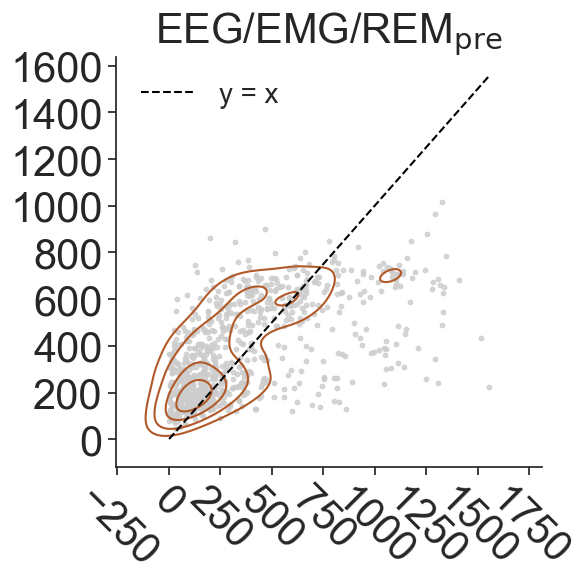

In [ ]:
from IPython.display import HTML, display
import base64

save_dir = '/content/drive/MyDrive/SleepClass/Revision/Examples'
os.makedirs(save_dir, exist_ok=True)

sns.set_style("white")
sns.set_style('ticks')
sns.regplot(x=y_test[::3], y=model.predict(x_test)[::3], fit_reg=False, scatter_kws={"color": "#CCCCCC", "s": 10})
sns.kdeplot(x=y_test[::3], y=model.predict(x_test)[::3], fill=False, levels=[0.25, 0.5, 0.75, 0.90, 1], bw_adjust=.8, color=palette[11])
sns.set(rc = {'figure.figsize':(6,6)})


min_val = min(min(y_test[::3]), min(model.predict(x_test)[::3]))
max_val = max(max(y_test[::3]), max(model.predict(x_test)[::3]))
plt.plot([min_val, max_val], [min_val, max_val], color="black",  linestyle='--', label='y = x')
plt.legend(fontsize=20, frameon=False)
# plt.xlabel('Actual time until next REM (s)', fontsize=20)
# plt.ylabel('Predicted time until next REM (s)', fontsize=20)

plt.xticks(fontsize=30, rotation=315)
plt.yticks(fontsize=30)
# plt.title('EMG/REM$_{\\mathrm{pre}}$/ET (T$_{\\mathrm{REM}}$ > 30)', fontsize=20)
title = 'EEG/EMG/REM$_{\\mathrm{pre}}$'
plt.title(title, fontsize=30)
# plt.title('All', fontsize=20)

sns.despine(top=True, right=True)
plt.rcParams['font.family'] = 'Arial'
plt.margins(x=0)
plt.tight_layout()
r2_score = model.score(x_test, y_test)

# # Add the R^2 score as text on the plot
# plt.text(x=700, y=500, s=f'R² Score: {r2_score:.2f}', fontsize=24, color='black')

# Save the figure immediately after plotting
svg_filepath = os.path.join(save_dir, '3B EEG, EMG, REMpre.svg')
plt.savefig(svg_filepath, format='svg')

# Display the SVG in the notebook (for verification)
with open(svg_filepath, 'r') as f:
    svg_data = f.read()
    display(HTML(f'<embed type="image/svg+xml" src="data:image/svg+xml;base64,{base64.b64encode(svg_data.encode()).decode()}" />'))

print(f"SVG file saved to: {svg_filepath}")

plt.show()

In [ ]:
r2_score

0.3110076507090237

In [ ]:
x_train = np.hstack((df_train['eeg_emg'].tolist(), df_train['elapsed_time'].values.reshape(-1, 1)))
y_train = df_train['time_until_REM'].values
x_test = np.hstack(( df_test['eeg_emg'].tolist(), df_test['elapsed_time'].values.reshape(-1, 1)))
y_test = df_test['time_until_REM'].values


model = RandomForestRegressor(n_estimators=100)
model.fit(x_train, y_train)

RandomForestRegressor()

SVG file saved to: /content/drive/MyDrive/SleepClass/Revision/Examples/3B EEG, EMG, ET.svg


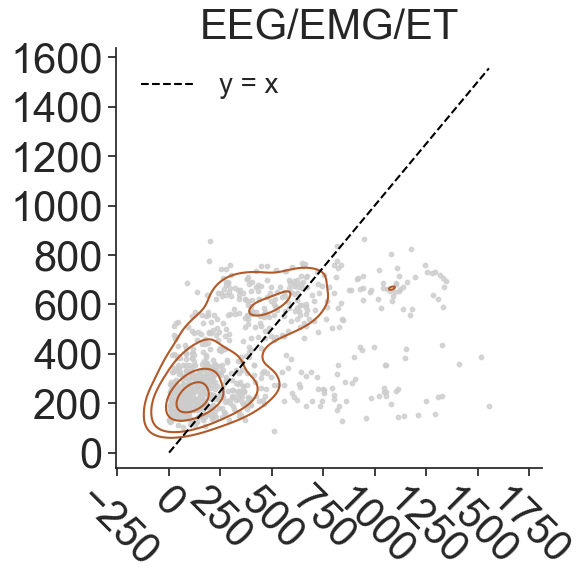

In [ ]:
from IPython.display import HTML, display
import base64

save_dir = '/content/drive/MyDrive/SleepClass/Revision/Examples'
os.makedirs(save_dir, exist_ok=True)

sns.set_style("white")
sns.set_style('ticks')
sns.regplot(x=y_test[::3], y=model.predict(x_test)[::3], fit_reg=False, scatter_kws={"color": "#CCCCCC", "s": 10})
sns.kdeplot(x=y_test[::3], y=model.predict(x_test)[::3], fill=False, levels=[0.25, 0.5, 0.75, 0.90, 1], bw_adjust=.8, color=palette[11])
sns.set(rc = {'figure.figsize':(6,6)})


min_val = min(min(y_test[::3]), min(model.predict(x_test)[::3]))
max_val = max(max(y_test[::3]), max(model.predict(x_test)[::3]))
plt.plot([min_val, max_val], [min_val, max_val], color="black",  linestyle='--', label='y = x')
plt.legend(fontsize=20, frameon=False)
# plt.xlabel('Actual time until next REM (s)', fontsize=20)
# plt.ylabel('Predicted time until next REM (s)', fontsize=20)

plt.xticks(fontsize=30, rotation=315)
plt.yticks(fontsize=30)
# plt.title('EMG/REM$_{\\mathrm{pre}}$/ET (T$_{\\mathrm{REM}}$ > 30)', fontsize=20)
title = 'EEG/EMG/ET'
plt.title(title, fontsize=30)
# plt.title('All', fontsize=20)

sns.despine(top=True, right=True)
plt.rcParams['font.family'] = 'Arial'
plt.margins(x=0)
plt.tight_layout()
r2_score = model.score(x_test, y_test)

# # Add the R^2 score as text on the plot
# plt.text(x=700, y=500, s=f'R² Score: {r2_score:.2f}', fontsize=24, color='black')

# Save the figure immediately after plotting
svg_filepath = os.path.join(save_dir, '3B EEG, EMG, ET.svg')
plt.savefig(svg_filepath, format='svg')

# Display the SVG in the notebook (for verification)
with open(svg_filepath, 'r') as f:
    svg_data = f.read()
    display(HTML(f'<embed type="image/svg+xml" src="data:image/svg+xml;base64,{base64.b64encode(svg_data.encode()).decode()}" />'))

print(f"SVG file saved to: {svg_filepath}")

plt.show()

In [ ]:
r2_score

0.2461040253785397

In [ ]:
y_train = df_train['time_until_REM'].values
x_train = np.array(df_train['eeg_emg'].to_list()).reshape(len(y_train), -1)
y_test = df_test['time_until_REM'].values
x_test = np.array(df_test['eeg_emg'].to_list()).reshape(len(y_test), -1)

In [ ]:
from sklearn.ensemble  import RandomForestRegressor

model = RandomForestRegressor(n_estimators=100)
model.fit(x_train, y_train)

RandomForestRegressor()

SVG file saved to: /content/drive/MyDrive/SleepClass/Revision/Examples/3B Control.svg


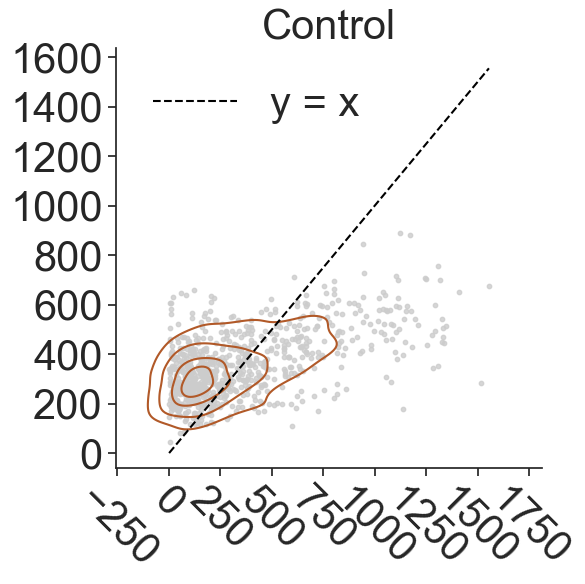

In [ ]:
from IPython.display import HTML, display
import base64

save_dir = '/content/drive/MyDrive/SleepClass/Revision/Examples'
os.makedirs(save_dir, exist_ok=True)

sns.set_style("white")
sns.set_style('ticks')
sns.regplot(x=y_test[::3], y=model.predict(x_test)[::3], fit_reg=False, scatter_kws={"color": "#CCCCCC", "s": 10})
sns.kdeplot(x=y_test[::3], y=model.predict(x_test)[::3], fill=False, levels=[0.25, 0.5, 0.75, 0.90, 1], bw_adjust=.8, color=palette[11])
sns.set(rc = {'figure.figsize':(6,6)})


min_val = min(min(y_test[::3]), min(model.predict(x_test)[::3]))
max_val = max(max(y_test[::3]), max(model.predict(x_test)[::3]))
plt.plot([min_val, max_val], [min_val, max_val], color="black",  linestyle='--', label='y = x')
plt.legend(fontsize=30, frameon=False)
# plt.xlabel('Actual time until next REM (s)', fontsize=20)
# plt.ylabel('Predicted time until next REM (s)', fontsize=20)

plt.xticks(fontsize=30, rotation=315)
plt.yticks(fontsize=30)
# plt.title('EMG/REM$_{\\mathrm{pre}}$/ET (T$_{\\mathrm{REM}}$ > 30)', fontsize=20)
title = 'Control'
plt.title(title, fontsize=30)
# plt.title('All', fontsize=20)

sns.despine(top=True, right=True)
plt.rcParams['font.family'] = 'Arial'
plt.margins(x=0)
plt.tight_layout()
r2_score = model.score(x_test, y_test)

# # Add the R^2 score as text on the plot
# plt.text(x=700, y=500, s=f'R² Score: {r2_score:.2f}', fontsize=24, color='black')

# Save the figure immediately after plotting
svg_filepath = os.path.join(save_dir, '3B Control.svg')
plt.savefig(svg_filepath, format='svg')

# Display the SVG in the notebook (for verification)
with open(svg_filepath, 'r') as f:
    svg_data = f.read()
    display(HTML(f'<embed type="image/svg+xml" src="data:image/svg+xml;base64,{base64.b64encode(svg_data.encode()).decode()}" />'))

print(f"SVG file saved to: {svg_filepath}")

plt.show()

In [ ]:
r2_score

In [ ]:
x_train = np.hstack((df_train['REMpre'].values.reshape(-1, 1), df_train['elapsed_time'].values.reshape(-1, 1)))
y_train = df_train['time_until_REM'].values
x_test = np.hstack((df_test['REMpre'].values.reshape(-1, 1), df_test['elapsed_time'].values.reshape(-1, 1)))
y_test = df_test['time_until_REM'].values

In [ ]:
from sklearn.ensemble  import RandomForestRegressor

model = RandomForestRegressor(n_estimators=100)
model.fit(x_train, y_train)

In [ ]:
from IPython.display import HTML, display
import base64

save_dir = '/content/drive/MyDrive/SleepClass/Revision/Examples'
os.makedirs(save_dir, exist_ok=True)

sns.set_style("white")
sns.set_style('ticks')
sns.regplot(x=y_test[::3], y=model.predict(x_test)[::3], fit_reg=False, scatter_kws={"color": "#CCCCCC", "s": 10})
sns.kdeplot(x=y_test[::3], y=model.predict(x_test)[::3], fill=False, levels=[0.25, 0.5, 0.75, 0.90, 1], bw_adjust=.8, color=palette[11])
sns.set(rc = {'figure.figsize':(6,6)})


min_val = min(min(y_test[::3]), min(model.predict(x_test)[::3]))
max_val = max(max(y_test[::3]), max(model.predict(x_test)[::3]))
plt.plot([min_val, max_val], [min_val, max_val], color="black",  linestyle='--', label='y = x')
plt.legend(fontsize=20, frameon=False)
plt.xlabel('Actual time until next REM (s)', fontsize=20)
plt.ylabel('Predicted time until next REM (s)', fontsize=20)

plt.xticks(fontsize=20, rotation=315)
plt.yticks(fontsize=20)
# plt.title('EMG/REM$_{\\mathrm{pre}}$/ET (T$_{\\mathrm{REM}}$ > 30)', fontsize=20)
title = 'EMG Only'
plt.title(title, fontsize=20)
# plt.title('All', fontsize=20)

sns.despine(top=True, right=True)
plt.rcParams['font.family'] = 'Arial'
plt.margins(x=0)
plt.tight_layout()
r2_score = model.score(x_test, y_test)

# # Add the R^2 score as text on the plot
# plt.text(x=700, y=500, s=f'R² Score: {r2_score:.2f}', fontsize=24, color='black')

# Save the figure immediately after plotting
svg_filepath = os.path.join(save_dir, '3B EMG Only.svg')
plt.savefig(svg_filepath, format='svg')

# Display the SVG in the notebook (for verification)
with open(svg_filepath, 'r') as f:
    svg_data = f.read()
    display(HTML(f'<embed type="image/svg+xml" src="data:image/svg+xml;base64,{base64.b64encode(svg_data.encode()).decode()}" />'))

print(f"SVG file saved to: {svg_filepath}")

plt.show()

In [ ]:
r2_score